In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 191, 192, 193, 194, 195, 196, 197, 198,
       199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237,
       238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250,
       251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 267, 268, 269, 270, 271]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [4]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [5]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3

In [6]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]

In [7]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]

In [8]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]

In [9]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]

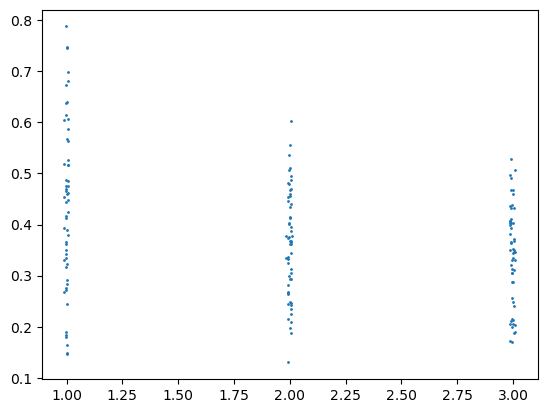

In [10]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)

In [11]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

In [12]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

(166, 3)


In [14]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [13]:
net = network.BallStickNet(gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [15]:
loss_list=[]
avg_loss_list=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 20

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss)
    avg_loss_list.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 178.64it/s]


Loss: 515.3374904934317
Average Loss: 0.07051689798760696
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.44it/s]


Loss: 432.68595031136647
Average Loss: 0.059207163425200666
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.73it/s]


Loss: 429.93762097880244
Average Loss: 0.05883109208795874
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.80it/s]


Loss: 429.3416462340392
Average Loss: 0.05874954108292819
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.47it/s]


Loss: 428.2020826828666
Average Loss: 0.05859360737313445
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.45it/s]


Loss: 427.1281965272501
Average Loss: 0.05844666071801452
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 170.22it/s]


Loss: 427.15105685126036
Average Loss: 0.05844978884116863
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.38it/s]


Loss: 426.3984299204312
Average Loss: 0.05834680212375906
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 166.83it/s]


Loss: 426.3610714771785
Average Loss: 0.05834169013097681
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 145.32it/s]


Loss: 425.36462508980185
Average Loss: 0.058205340050602336
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|██▌                                                                                                                                                           | 120/7308 [00:04<01:11, 100.66it/s]

X_batch: 
torch.Size([128, 166])
tensor([[0.1931, 0.0907, 0.0666,  ..., 0.1855, 0.0573, 0.0678],
        [0.7170, 1.2499, 0.7418,  ..., 1.1154, 1.2905, 0.6843],
        [0.0518, 0.0416, 0.0382,  ..., 0.0350, 0.0379, 0.0234],
        ...,
        [0.4661, 0.2413, 0.1291,  ..., 0.3763, 0.1668, 0.2330],
        [0.3939, 0.1775, 0.1735,  ..., 0.3751, 0.1149, 0.1855],
        [0.4925, 0.3598, 0.2003,  ..., 0.5150, 0.1426, 0.3287]])
X_pred: 
torch.Size([128, 166])
tensor([[0.1789, 0.0856, 0.0621,  ..., 0.1736, 0.0678, 0.0838],
        [0.8727, 0.8175, 0.7871,  ..., 0.8945, 0.7549, 0.8724],
        [0.0757, 0.0286, 0.0217,  ..., 0.0736, 0.0235, 0.0282],
        ...,
        [0.4624, 0.2672, 0.1679,  ..., 0.4512, 0.1837, 0.2582],
        [0.4035, 0.2051, 0.1225,  ..., 0.3961, 0.1295, 0.2037],
        [0.5192, 0.2895, 0.1657,  ..., 0.5128, 0.1723, 0.2862]],
       grad_fn=<AddBackward0>)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.80it/s]


Loss: 425.5618253503926
Average Loss: 0.05823232421324475
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.62it/s]


Loss: 426.6561475605704
Average Loss: 0.05838206726335118
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 2


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:25<00:00, 85.89it/s]


Loss: 425.68703915923834
Average Loss: 0.058249458013032065
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 3


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 94.44it/s]


Loss: 425.4926929883659
Average Loss: 0.058222864393591395
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.86it/s]


Loss: 425.4767942111939
Average Loss: 0.05822068886305336
-----------------------------------------------------------------
Epoch: 15; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.77it/s]


Loss: 424.66855924902484
Average Loss: 0.05811009294595304
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 16; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:47<00:00, 154.43it/s]


Loss: 424.76639612484723
Average Loss: 0.05812348058632283
-----------------------------------------------------------------
Epoch: 17; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:49<00:00, 147.66it/s]


Loss: 424.3879713783972
Average Loss: 0.05807169832764056
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 18; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:46<00:00, 157.35it/s]


Loss: 424.5643820040859
Average Loss: 0.05809583771265544
-----------------------------------------------------------------
Epoch: 19; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.45it/s]


Loss: 424.02505170181394
Average Loss: 0.05802203772602818
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 20; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.04it/s]


Loss: 424.1947726723738
Average Loss: 0.05804526172309439
-----------------------------------------------------------------
Epoch: 21; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 187.53it/s]


Loss: 424.32431311998516
Average Loss: 0.05806298756431105
-----------------------------------------------------------------
Epoch: 22; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.60it/s]


Loss: 423.86818190524355
Average Loss: 0.05800057223662337
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 23; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.85it/s]


Loss: 423.8726510235574
Average Loss: 0.05800118377443314
-----------------------------------------------------------------
Epoch: 24; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.96it/s]


Loss: 424.15455134259537
Average Loss: 0.05803975798338743
-----------------------------------------------------------------
Epoch: 25; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.29it/s]


Loss: 423.65561556164175
Average Loss: 0.05797148543536423
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 26; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:53<00:00, 136.34it/s]


Loss: 423.31748503027484
Average Loss: 0.05792521688974751
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 27; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.02it/s]


Loss: 423.2497766572051
Average Loss: 0.057915951923536546
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 28; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.78it/s]


Loss: 423.3663530263584
Average Loss: 0.05793190380765714
-----------------------------------------------------------------
Epoch: 29; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.35it/s]


Loss: 423.0660088986624
Average Loss: 0.05789080581536157
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 30; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.73it/s]


Loss: 422.9225175632164
Average Loss: 0.057871170985661795
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 31; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.87it/s]


Loss: 422.7572437012568
Average Loss: 0.05784855551467663
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 32; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.46it/s]


Loss: 422.72123825224116
Average Loss: 0.05784362866067887
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 33; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.58it/s]


Loss: 422.0237533468753
Average Loss: 0.05774818737641972
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 34; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.70it/s]


Loss: 422.1395161594264
Average Loss: 0.05776402793642945
-----------------------------------------------------------------
Epoch: 35; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.21it/s]


Loss: 421.5003562271595
Average Loss: 0.05767656762823748
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 36; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.70it/s]


Loss: 421.5186447198503
Average Loss: 0.05767907015870967
-----------------------------------------------------------------
Epoch: 37; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.39it/s]


Loss: 420.8252091545146
Average Loss: 0.05758418297133478
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 38; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.27it/s]


Loss: 420.89852586458437
Average Loss: 0.057594215361875256
-----------------------------------------------------------------
Epoch: 39; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.87it/s]


Loss: 420.76710584317334
Average Loss: 0.05757623232665207
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 40; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.86it/s]


Loss: 420.60884296288714
Average Loss: 0.05755457621276507
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 41; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.89it/s]


Loss: 420.82578341290355
Average Loss: 0.05758426155075309
-----------------------------------------------------------------
Epoch: 42; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.30it/s]


Loss: 420.53964833100326
Average Loss: 0.057545107872332135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 43; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.98it/s]


Loss: 420.62762105627917
Average Loss: 0.05755714573840711
-----------------------------------------------------------------
Epoch: 44; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 195.83it/s]


Loss: 420.468948350288
Average Loss: 0.05753543354546907
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 45; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.33it/s]


Loss: 420.2143645770848
Average Loss: 0.05750059723277022
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 46; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.84it/s]


Loss: 420.3902691025287
Average Loss: 0.05752466736487804
-----------------------------------------------------------------
Epoch: 47; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.26it/s]


Loss: 420.1550001706928
Average Loss: 0.05749247402445167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 48; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:43<00:00, 167.91it/s]


Loss: 420.092071459163
Average Loss: 0.05748386308965011
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 49; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.10it/s]


Loss: 419.90576328057796
Average Loss: 0.057458369359685
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 50; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.90it/s]


Loss: 419.6363437776454
Average Loss: 0.057421502979973366
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 51; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.98it/s]


Loss: 419.7583036113065
Average Loss: 0.057438191517693825
-----------------------------------------------------------------
Epoch: 52; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 163.00it/s]


Loss: 419.4499907407444
Average Loss: 0.05739600311176032
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 53; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:44<00:00, 162.51it/s]


Loss: 419.8236851610709
Average Loss: 0.05744713808991118
-----------------------------------------------------------------
Epoch: 54; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.30it/s]


Loss: 419.47884854185395
Average Loss: 0.05739995190775232
-----------------------------------------------------------------
Epoch: 55; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 176.42it/s]


Loss: 419.7712559942156
Average Loss: 0.05743996387441374
-----------------------------------------------------------------
Epoch: 56; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 181.45it/s]


Loss: 419.45340338512324
Average Loss: 0.05739647008553958
-----------------------------------------------------------------
Epoch: 57; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 175.45it/s]


Loss: 419.50181187177077
Average Loss: 0.05740309412585807
-----------------------------------------------------------------
Epoch: 58; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:42<00:00, 173.91it/s]


Loss: 419.49957825406455
Average Loss: 0.05740278848577785
-----------------------------------------------------------------
Epoch: 59; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:04<00:00, 112.73it/s]


Loss: 419.631755088456
Average Loss: 0.05742087508052216
-----------------------------------------------------------------
Epoch: 60; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:11<00:00, 101.86it/s]


Loss: 419.4522580783814
Average Loss: 0.05739631336595258
-----------------------------------------------------------------
Epoch: 61; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:45<00:00, 160.91it/s]


Loss: 419.5289099207148
Average Loss: 0.05740680212379787
-----------------------------------------------------------------
Epoch: 62; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:03<00:00, 115.33it/s]


Loss: 419.17594893532805
Average Loss: 0.05735850423307718
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 63; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [04:07<00:00, 29.52it/s]


Loss: 419.1457634982653
Average Loss: 0.05735437376823554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 64; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:40<00:00, 182.01it/s]


Loss: 419.4408824541606
Average Loss: 0.05739475676712652
-----------------------------------------------------------------
Epoch: 65; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [23:02<00:00,  5.29it/s]


Loss: 418.94026967929676
Average Loss: 0.057326254745388175
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 66; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.65it/s]


Loss: 419.0581918314565
Average Loss: 0.05734239078153482
-----------------------------------------------------------------
Epoch: 67; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.42it/s]


Loss: 419.18952954444103
Average Loss: 0.057360362553973865
-----------------------------------------------------------------
Epoch: 68; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.86it/s]


Loss: 419.0163055800367
Average Loss: 0.05733665922003787
-----------------------------------------------------------------
Epoch: 69; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.96it/s]


Loss: 418.98824954149313
Average Loss: 0.05733282013430393
-----------------------------------------------------------------
Epoch: 70; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.01it/s]


Loss: 419.0384909149725
Average Loss: 0.05733969498015497
-----------------------------------------------------------------
Epoch: 71; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.24it/s]


Loss: 418.9297322181519
Average Loss: 0.057324812837732886
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 72; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.67it/s]


Loss: 418.9406766591128
Average Loss: 0.05732631043501817
-----------------------------------------------------------------
Epoch: 73; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.97it/s]


Loss: 418.8523603514768
Average Loss: 0.057314225554389274
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 74; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.88it/s]


Loss: 418.7751097958535
Average Loss: 0.05730365487080644
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 75; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.06it/s]


Loss: 418.81661721598357
Average Loss: 0.057309334594414826
-----------------------------------------------------------------
Epoch: 76; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.01it/s]


Loss: 415.4032916717697
Average Loss: 0.05684226760697451
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 77; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.64it/s]


Loss: 413.97671704972163
Average Loss: 0.05664706035163131
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 78; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.41it/s]


Loss: 413.68074415274896
Average Loss: 0.05660656050256554
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 79; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.77it/s]


Loss: 412.89343887823634
Average Loss: 0.05649882852739961
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 80; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.33it/s]


Loss: 412.43064035568386
Average Loss: 0.05643550086968854
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 81; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.53it/s]


Loss: 412.3081901250407
Average Loss: 0.05641874522783808
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 82; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.07it/s]


Loss: 411.9214966604486
Average Loss: 0.05636583150799789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 83; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.36it/s]


Loss: 411.7722339301836
Average Loss: 0.05634540694173284
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 84; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.81it/s]


Loss: 411.6741912215948
Average Loss: 0.05633199113595988
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 85; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.37it/s]


Loss: 411.41378930490464
Average Loss: 0.05629635868977896
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 86; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.52it/s]


Loss: 411.28341980464756
Average Loss: 0.056278519404029496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 87; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.78it/s]


Loss: 411.141380767338
Average Loss: 0.05625908330149671
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 88; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.19it/s]


Loss: 411.0780983194709
Average Loss: 0.056250423962708115
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 89; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.12it/s]


Loss: 410.8254271992482
Average Loss: 0.05621584937044995
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 90; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.53it/s]


Loss: 410.85525700007565
Average Loss: 0.05621993117132945
-----------------------------------------------------------------
Epoch: 91; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.15it/s]


Loss: 410.5815815385431
Average Loss: 0.05618248242180393
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 92; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.36it/s]


Loss: 410.62195291835815
Average Loss: 0.05618800669380927
-----------------------------------------------------------------
Epoch: 93; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.64it/s]


Loss: 410.17729438189417
Average Loss: 0.05612716124546992
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 94; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.87it/s]


Loss: 410.2846949712839
Average Loss: 0.05614185754943677
-----------------------------------------------------------------
Epoch: 95; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.45it/s]


Loss: 410.2653018934652
Average Loss: 0.05613920387157433
-----------------------------------------------------------------
Epoch: 96; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.77it/s]


Loss: 410.3289030950982
Average Loss: 0.05614790682746281
-----------------------------------------------------------------
Epoch: 97; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.98it/s]


Loss: 410.15777638880536
Average Loss: 0.056124490474658645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 98; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.63it/s]


Loss: 410.0094840785023
Average Loss: 0.05610419869711306
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 99; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.68it/s]


Loss: 409.95498577156104
Average Loss: 0.05609674134805159
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 100; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.22it/s]


Loss: 409.681482011918
Average Loss: 0.05605931609358483
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 101; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.11it/s]


Loss: 409.663824866293
Average Loss: 0.056056899954336756
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 102; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.90it/s]


Loss: 409.65187658998184
Average Loss: 0.056055264995892425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 103; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.64it/s]


Loss: 409.69975353917107
Average Loss: 0.05606181630256857
-----------------------------------------------------------------
Epoch: 104; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.42it/s]


Loss: 409.6754423233215
Average Loss: 0.05605848964468001
-----------------------------------------------------------------
Epoch: 105; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.74it/s]


Loss: 409.6463417336345
Average Loss: 0.056054507626386765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 106; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.53it/s]


Loss: 409.47274957760237
Average Loss: 0.056030753910454624
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 107; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.13it/s]


Loss: 409.30521397828124
Average Loss: 0.05600782895159842
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 108; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.71it/s]


Loss: 409.1936125799548
Average Loss: 0.05599255782429595
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 109; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.16it/s]


Loss: 409.3520351983607
Average Loss: 0.0560142357961632
-----------------------------------------------------------------
Epoch: 110; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:56<00:00, 128.88it/s]


Loss: 409.3809016086161
Average Loss: 0.05601818577019925
-----------------------------------------------------------------
Epoch: 111; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:52<00:00, 140.06it/s]


Loss: 409.1834305913653
Average Loss: 0.055991164558205436
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 112; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.87it/s]


Loss: 409.2489872467704
Average Loss: 0.056000135091238426
-----------------------------------------------------------------
Epoch: 113; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.08it/s]


Loss: 409.26482580206357
Average Loss: 0.05600230238123475
-----------------------------------------------------------------
Epoch: 114; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.08it/s]


Loss: 409.2216795182321
Average Loss: 0.05599639840150959
-----------------------------------------------------------------
Epoch: 115; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.90it/s]


Loss: 409.1202370240353
Average Loss: 0.05598251738150456
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 116; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.28it/s]


Loss: 409.02948421332985
Average Loss: 0.05597009909870414
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 117; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.15it/s]


Loss: 408.83289688429795
Average Loss: 0.0559431988073752
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 118; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.62it/s]


Loss: 408.82052387017757
Average Loss: 0.05594150572936201
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 119; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.80it/s]


Loss: 409.00201252871193
Average Loss: 0.05596633997382484
-----------------------------------------------------------------
Epoch: 120; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.08it/s]


Loss: 408.7279225147795
Average Loss: 0.05592883449846463
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 121; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.23it/s]


Loss: 408.618649414042
Average Loss: 0.05591388196689135
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 122; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.07it/s]


Loss: 408.74050207971595
Average Loss: 0.05593055584013628
-----------------------------------------------------------------
Epoch: 123; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.72it/s]


Loss: 408.85487524070777
Average Loss: 0.05594620624530758
-----------------------------------------------------------------
Epoch: 124; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 198.22it/s]


Loss: 408.5551277983468
Average Loss: 0.055905189901251616
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 125; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.25it/s]


Loss: 408.5250249153469
Average Loss: 0.055901070732806084
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 126; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.99it/s]


Loss: 408.67056670528837
Average Loss: 0.055920986139202024
-----------------------------------------------------------------
Epoch: 127; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.89it/s]


Loss: 408.5434671130497
Average Loss: 0.05590359429571014
-----------------------------------------------------------------
Epoch: 128; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.33it/s]


Loss: 408.64706576871686
Average Loss: 0.055917770356967274
-----------------------------------------------------------------
Epoch: 129; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.67it/s]


Loss: 408.4307522333693
Average Loss: 0.05588817080369038
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 130; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.61it/s]


Loss: 408.56044031097554
Average Loss: 0.05590591684605577
-----------------------------------------------------------------
Epoch: 131; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 190.29it/s]


Loss: 408.43379871034995
Average Loss: 0.05588858767246168
-----------------------------------------------------------------
Epoch: 132; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.64it/s]


Loss: 408.6261151977815
Average Loss: 0.05591490355744136
-----------------------------------------------------------------
Epoch: 133; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.43it/s]


Loss: 408.5116151829716
Average Loss: 0.055899235794057416
-----------------------------------------------------------------
Epoch: 134; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.81it/s]


Loss: 408.3655888037756
Average Loss: 0.05587925407823968
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 135; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.82it/s]


Loss: 408.25644020340405
Average Loss: 0.05586431858284128
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 136; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.55it/s]


Loss: 408.17033479362726
Average Loss: 0.0558525362333918
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 137; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.49it/s]


Loss: 408.28549549216405
Average Loss: 0.0558682944023213
-----------------------------------------------------------------
Epoch: 138; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.31it/s]


Loss: 408.3848412288353
Average Loss: 0.05588188850969284
-----------------------------------------------------------------
Epoch: 139; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.68it/s]


Loss: 408.215506095672
Average Loss: 0.05585871730920526
-----------------------------------------------------------------
Epoch: 140; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.92it/s]


Loss: 408.42875435901806
Average Loss: 0.05588789742186892
-----------------------------------------------------------------
Epoch: 141; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.16it/s]


Loss: 408.083110999316
Average Loss: 0.05584060084829173
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 142; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.26it/s]


Loss: 408.1138292646501
Average Loss: 0.055844804223405875
-----------------------------------------------------------------
Epoch: 143; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.92it/s]


Loss: 408.0799558926374
Average Loss: 0.055840169115029745
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 144; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.35it/s]


Loss: 408.1739194744732
Average Loss: 0.05585302674801221
-----------------------------------------------------------------
Epoch: 145; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.61it/s]


Loss: 408.120605918346
Average Loss: 0.05584573151592036
-----------------------------------------------------------------
Epoch: 146; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.57it/s]


Loss: 408.1579583939165
Average Loss: 0.0558508426921068
-----------------------------------------------------------------
Epoch: 147; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.88it/s]


Loss: 407.938205658691
Average Loss: 0.05582077253129324
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 148; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [01:00<00:00, 120.69it/s]


Loss: 407.9877092803363
Average Loss: 0.05582754642588072
-----------------------------------------------------------------
Epoch: 149; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:50<00:00, 144.20it/s]


Loss: 408.12893177126534
Average Loss: 0.0558468707951923
-----------------------------------------------------------------
Epoch: 150; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.63it/s]


Loss: 407.8874409941491
Average Loss: 0.0558138260802065
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 151; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.67it/s]


Loss: 407.9315950467717
Average Loss: 0.05581986795932836
-----------------------------------------------------------------
Epoch: 152; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.04it/s]


Loss: 407.7837620957289
Average Loss: 0.05579963903882442
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 153; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 230.42it/s]


Loss: 407.8075023321435
Average Loss: 0.05580288756597475
-----------------------------------------------------------------
Epoch: 154; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.59it/s]


Loss: 407.7865200336091
Average Loss: 0.0558000164249602
-----------------------------------------------------------------
Epoch: 155; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 183.27it/s]


Loss: 407.88007349707186
Average Loss: 0.05581281793884399
-----------------------------------------------------------------
Epoch: 156; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.97it/s]


Loss: 407.8997219821904
Average Loss: 0.055815506565707496
-----------------------------------------------------------------
Epoch: 157; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.25it/s]


Loss: 407.82926382357255
Average Loss: 0.05580586532889608
-----------------------------------------------------------------
Epoch: 158; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.17it/s]


Loss: 407.75924764946103
Average Loss: 0.055796284571628496
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 159; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.68it/s]


Loss: 407.83219594252296
Average Loss: 0.05580626654933264
-----------------------------------------------------------------
Epoch: 160; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.90it/s]


Loss: 407.77403287403286
Average Loss: 0.05579830772770017
-----------------------------------------------------------------
Epoch: 161; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.10it/s]


Loss: 407.8344086713623
Average Loss: 0.055806569331056696
-----------------------------------------------------------------
Epoch: 162; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.61it/s]


Loss: 407.6628640429117
Average Loss: 0.05578309579131249
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 163; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 192.09it/s]


Loss: 407.6308048584033
Average Loss: 0.0557787089297213
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 164; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.28it/s]


Loss: 407.5930396155454
Average Loss: 0.05577354127196845
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 165; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 184.84it/s]


Loss: 407.6524200681597
Average Loss: 0.055781666675993394
-----------------------------------------------------------------
Epoch: 166; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.30it/s]


Loss: 407.61486806115136
Average Loss: 0.05577652819665454
-----------------------------------------------------------------
Epoch: 167; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.84it/s]


Loss: 407.55806087958626
Average Loss: 0.0557687549096314
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 168; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.76it/s]


Loss: 407.55089459824376
Average Loss: 0.05576777430189433
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 169; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.79it/s]


Loss: 407.6698904479854
Average Loss: 0.055784057258892364
-----------------------------------------------------------------
Epoch: 170; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.70it/s]


Loss: 407.45473199663684
Average Loss: 0.055754615763086594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 171; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.18it/s]


Loss: 407.51219887984917
Average Loss: 0.0557624793212711
-----------------------------------------------------------------
Epoch: 172; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:39<00:00, 185.34it/s]


Loss: 407.55670297844335
Average Loss: 0.05576856909940385
-----------------------------------------------------------------
Epoch: 173; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.15it/s]


Loss: 407.5231749303639
Average Loss: 0.05576398124389216
-----------------------------------------------------------------
Epoch: 174; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.28it/s]


Loss: 407.63664142694324
Average Loss: 0.055779507584420254
-----------------------------------------------------------------
Epoch: 175; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.82it/s]


Loss: 407.6117238192819
Average Loss: 0.055776097950093306
-----------------------------------------------------------------
Epoch: 176; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.66it/s]


Loss: 407.61509767896496
Average Loss: 0.055776559616716605
-----------------------------------------------------------------
Epoch: 177; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.09it/s]


Loss: 407.4325872720219
Average Loss: 0.05575158555993732
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 178; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.33it/s]


Loss: 407.46080577909015
Average Loss: 0.05575544687727014
-----------------------------------------------------------------
Epoch: 179; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 188.94it/s]


Loss: 407.4766746072564
Average Loss: 0.055757618309695736
-----------------------------------------------------------------
Epoch: 180; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.39it/s]


Loss: 407.42934119864367
Average Loss: 0.05575114137912475
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 181; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.51it/s]


Loss: 407.4794394252822
Average Loss: 0.055757996637285465
-----------------------------------------------------------------
Epoch: 182; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.46it/s]


Loss: 407.5234335921705
Average Loss: 0.05576401663822803
-----------------------------------------------------------------
Epoch: 183; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.38it/s]


Loss: 407.4107783208601
Average Loss: 0.05574860130279969
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 184; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 228.20it/s]


Loss: 407.48379193083383
Average Loss: 0.05575859221823123
-----------------------------------------------------------------
Epoch: 185; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.28it/s]


Loss: 407.49416354624555
Average Loss: 0.055760011432162776
-----------------------------------------------------------------
Epoch: 186; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.09it/s]


Loss: 407.4493082619738
Average Loss: 0.055753873599065924
-----------------------------------------------------------------
Epoch: 187; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.48it/s]


Loss: 407.31190775497817
Average Loss: 0.055735072216061596
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 188; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.95it/s]


Loss: 407.32747627957724
Average Loss: 0.05573720255604505
-----------------------------------------------------------------
Epoch: 189; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.93it/s]


Loss: 407.58490820252337
Average Loss: 0.05577242859914113
-----------------------------------------------------------------
Epoch: 190; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:38<00:00, 191.28it/s]


Loss: 407.40688453335315
Average Loss: 0.05574806849115396
-----------------------------------------------------------------
Epoch: 191; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.38it/s]


Loss: 407.25483268196695
Average Loss: 0.055727262271752454
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 192; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.16it/s]


Loss: 407.417844080599
Average Loss: 0.055749568155528055
-----------------------------------------------------------------
Epoch: 193; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.94it/s]


Loss: 407.35993873048574
Average Loss: 0.05574164459913598
-----------------------------------------------------------------
Epoch: 194; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.30it/s]


Loss: 407.2752509901766
Average Loss: 0.05573005623839307
-----------------------------------------------------------------
Epoch: 195; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.82it/s]


Loss: 407.2529615156818
Average Loss: 0.05572700622819948
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 196; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.08it/s]


Loss: 407.26454191235825
Average Loss: 0.055728590847339665
-----------------------------------------------------------------
Epoch: 197; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.36it/s]


Loss: 407.1927921229508
Average Loss: 0.05571877286849354
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 198; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.39it/s]


Loss: 407.18168656225316
Average Loss: 0.05571725322417257
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 199; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.89it/s]


Loss: 407.14761181524955
Average Loss: 0.05571259056037897
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 200; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 174.33it/s]


Loss: 407.38158746482804
Average Loss: 0.05574460693278983
-----------------------------------------------------------------
Epoch: 201; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:41<00:00, 177.97it/s]


Loss: 407.1896274711471
Average Loss: 0.055718339829111535
-----------------------------------------------------------------
Epoch: 202; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.76it/s]


Loss: 407.11126679577865
Average Loss: 0.05570761724080168
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 203; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 194.57it/s]


Loss: 407.21239510923624
Average Loss: 0.05572145526946309
-----------------------------------------------------------------
Epoch: 204; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.58it/s]


Loss: 407.2751641825307
Average Loss: 0.055730044359952206
-----------------------------------------------------------------
Epoch: 205; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.58it/s]


Loss: 407.2024554191157
Average Loss: 0.05572009515860916
-----------------------------------------------------------------
Epoch: 206; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.83it/s]


Loss: 407.15655611571856
Average Loss: 0.0557138144657524
-----------------------------------------------------------------
Epoch: 207; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.73it/s]


Loss: 407.20849358593114
Average Loss: 0.055720921399279026
-----------------------------------------------------------------
Epoch: 208; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.45it/s]


Loss: 407.36374460114166
Average Loss: 0.05574216538056126
-----------------------------------------------------------------
Epoch: 209; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.39it/s]


Loss: 407.03965278272517
Average Loss: 0.0556978178410954
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 210; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.00it/s]


Loss: 407.0345954382792
Average Loss: 0.05569712581257241
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 211; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.43it/s]


Loss: 407.1167256135959
Average Loss: 0.05570836420547289
-----------------------------------------------------------------
Epoch: 212; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.07it/s]


Loss: 407.23782938928343
Average Loss: 0.05572493560335022
-----------------------------------------------------------------
Epoch: 213; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.25it/s]


Loss: 407.16361768823117
Average Loss: 0.055714780745516036
-----------------------------------------------------------------
Epoch: 214; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.16it/s]


Loss: 407.3535908453632
Average Loss: 0.05574077597774538
-----------------------------------------------------------------
Epoch: 215; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.10it/s]


Loss: 407.2257799934596
Average Loss: 0.055723286808081494
-----------------------------------------------------------------
Epoch: 216; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.39it/s]


Loss: 407.2331065137405
Average Loss: 0.05572428934232902
-----------------------------------------------------------------
Epoch: 217; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.07it/s]


Loss: 407.0961446533911
Average Loss: 0.055705547982127956
-----------------------------------------------------------------
Epoch: 218; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.44it/s]


Loss: 406.9900890151039
Average Loss: 0.05569103571635247
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 219; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.62it/s]


Loss: 406.96755446190946
Average Loss: 0.055687952170485694
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 220; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.28it/s]


Loss: 407.09850718360394
Average Loss: 0.055705871262124236
-----------------------------------------------------------------
Epoch: 221; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 231.86it/s]


Loss: 407.30471493140794
Average Loss: 0.055734087976383136
-----------------------------------------------------------------
Epoch: 222; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.32it/s]


Loss: 406.9933215463534
Average Loss: 0.05569147804410966
-----------------------------------------------------------------
Epoch: 223; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.43it/s]


Loss: 407.1090702584479
Average Loss: 0.05570731667466446
-----------------------------------------------------------------
Epoch: 224; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.10it/s]


Loss: 407.0893022681121
Average Loss: 0.055704611695143964
-----------------------------------------------------------------
Epoch: 225; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.51it/s]


Loss: 406.95670214900747
Average Loss: 0.05568646717966714
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 226; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.19it/s]


Loss: 407.0367217955645
Average Loss: 0.05569741677552881
-----------------------------------------------------------------
Epoch: 227; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.17it/s]


Loss: 407.11961647006683
Average Loss: 0.05570875977970263
-----------------------------------------------------------------
Epoch: 228; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.59it/s]


Loss: 407.0396500332281
Average Loss: 0.05569781746486427
-----------------------------------------------------------------
Epoch: 229; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.81it/s]


Loss: 406.8894369411282
Average Loss: 0.05567726285456051
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 230; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.21it/s]


Loss: 406.96726409951225
Average Loss: 0.055687912438356905
-----------------------------------------------------------------
Epoch: 231; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.67it/s]


Loss: 406.96961641451344
Average Loss: 0.05568823432054097
-----------------------------------------------------------------
Epoch: 232; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.50it/s]


Loss: 406.99502548365854
Average Loss: 0.055691711204660446
-----------------------------------------------------------------
Epoch: 233; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.63it/s]


Loss: 407.081500725355
Average Loss: 0.05570354416055761
-----------------------------------------------------------------
Epoch: 234; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.70it/s]


Loss: 407.03064581169747
Average Loss: 0.05569658536011186
-----------------------------------------------------------------
Epoch: 235; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.99it/s]


Loss: 406.91304430854507
Average Loss: 0.05568049320040299
-----------------------------------------------------------------
Epoch: 236; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.15it/s]


Loss: 406.9904711062554
Average Loss: 0.05569108800030863
-----------------------------------------------------------------
Epoch: 237; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.30it/s]


Loss: 406.98731242935173
Average Loss: 0.05569065577851009
-----------------------------------------------------------------
Epoch: 238; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.35it/s]


Loss: 407.0749813739676
Average Loss: 0.055702652076350244
-----------------------------------------------------------------
Epoch: 239; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.10it/s]


Loss: 406.914573950693
Average Loss: 0.055680702511041735
-----------------------------------------------------------------
Epoch: 240; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 242.03it/s]


Loss: 406.84022628725506
Average Loss: 0.055670529048611805
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 241; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.63it/s]


Loss: 406.8447859995067
Average Loss: 0.055671152982964794
-----------------------------------------------------------------
Epoch: 242; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.50it/s]


Loss: 406.851275798399
Average Loss: 0.05567204102331678
-----------------------------------------------------------------
Epoch: 243; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.57it/s]


Loss: 406.89443180989474
Average Loss: 0.05567794633413995
-----------------------------------------------------------------
Epoch: 244; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.61it/s]


Loss: 406.9203426199965
Average Loss: 0.05568149187465743
-----------------------------------------------------------------
Epoch: 245; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.99it/s]


Loss: 406.94899717043154
Average Loss: 0.055685412858570274
-----------------------------------------------------------------
Epoch: 246; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.76it/s]


Loss: 407.0544498334639
Average Loss: 0.055699842615416516
-----------------------------------------------------------------
Epoch: 247; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.31it/s]


Loss: 406.99132955935784
Average Loss: 0.05569120546789243
-----------------------------------------------------------------
Epoch: 248; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.29it/s]


Loss: 406.90105046192184
Average Loss: 0.05567885200628378
-----------------------------------------------------------------
Epoch: 249; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.02it/s]


Loss: 406.9703960204497
Average Loss: 0.05568834099896684
-----------------------------------------------------------------
Epoch: 250; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.00it/s]


Loss: 406.896828584373
Average Loss: 0.055678274299996305
-----------------------------------------------------------------
Epoch: 251; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.10it/s]


Loss: 406.99627924431115
Average Loss: 0.055691882764684064
-----------------------------------------------------------------
Epoch: 252; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.83it/s]


Loss: 406.7735033878125
Average Loss: 0.055661398931008826
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 253; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.37it/s]


Loss: 406.8534151848871
Average Loss: 0.055672333769141644
-----------------------------------------------------------------
Epoch: 254; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.04it/s]


Loss: 406.92988710384816
Average Loss: 0.05568279790693051
-----------------------------------------------------------------
Epoch: 255; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.46it/s]


Loss: 406.80813650623895
Average Loss: 0.05566613800030637
-----------------------------------------------------------------
Epoch: 256; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 234.63it/s]


Loss: 406.85698363534175
Average Loss: 0.05567282206285465
-----------------------------------------------------------------
Epoch: 257; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 236.69it/s]


Loss: 406.8368806086946
Average Loss: 0.05567007123819029
-----------------------------------------------------------------
Epoch: 258; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.09it/s]


Loss: 406.8033445274923
Average Loss: 0.055665482283455435
-----------------------------------------------------------------
Epoch: 259; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.14it/s]


Loss: 406.89222266571596
Average Loss: 0.05567764404292774
-----------------------------------------------------------------
Epoch: 260; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.81it/s]


Loss: 407.1702555580996
Average Loss: 0.055715689047359004
-----------------------------------------------------------------
Epoch: 261; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.73it/s]


Loss: 406.82422934868373
Average Loss: 0.05566834008602678
-----------------------------------------------------------------
Epoch: 262; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 235.93it/s]


Loss: 406.909152392298
Average Loss: 0.05567996064481363
-----------------------------------------------------------------
Epoch: 263; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.71it/s]


Loss: 406.82558771478944
Average Loss: 0.05566852595987814
-----------------------------------------------------------------
Epoch: 264; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.72it/s]


Loss: 406.8624979783781
Average Loss: 0.05567357662539383
-----------------------------------------------------------------
Epoch: 265; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 232.02it/s]


Loss: 406.8042539798189
Average Loss: 0.055665606729586606
-----------------------------------------------------------------
Epoch: 266; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.61it/s]


Loss: 406.78182595362887
Average Loss: 0.05566253776048562
-----------------------------------------------------------------
Epoch: 267; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.10it/s]


Loss: 406.7811716014985
Average Loss: 0.05566244822133258
-----------------------------------------------------------------
Epoch: 268; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.26it/s]


Loss: 406.7728514948394
Average Loss: 0.05566130972835789
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 269; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 235.40it/s]


Loss: 406.8483372647315
Average Loss: 0.05567163892511378
-----------------------------------------------------------------
Epoch: 270; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 237.19it/s]


Loss: 406.77911297418177
Average Loss: 0.05566216652629745
-----------------------------------------------------------------
Epoch: 271; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 238.39it/s]


Loss: 406.7859335949179
Average Loss: 0.05566309983510097
-----------------------------------------------------------------
Epoch: 272; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.79it/s]


Loss: 406.85654448065907
Average Loss: 0.05567276197053354
-----------------------------------------------------------------
Epoch: 273; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.14it/s]


Loss: 406.9534070894588
Average Loss: 0.05568601629576612
-----------------------------------------------------------------
Epoch: 274; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.75it/s]


Loss: 406.7017543015536
Average Loss: 0.05565158104837898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 275; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.62it/s]


Loss: 406.7337949962821
Average Loss: 0.05565596537989629
-----------------------------------------------------------------
Epoch: 276; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 233.46it/s]


Loss: 406.764640301466
Average Loss: 0.05566018613867898
-----------------------------------------------------------------
Epoch: 277; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.68it/s]


Loss: 406.8025365106296
Average Loss: 0.05566537171738226
-----------------------------------------------------------------
Epoch: 278; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.70it/s]


Loss: 406.90334721584804
Average Loss: 0.05567916628569349
-----------------------------------------------------------------
Epoch: 279; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.85it/s]


Loss: 406.83160575758666
Average Loss: 0.05566934944685094
-----------------------------------------------------------------
Epoch: 280; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.63it/s]


Loss: 406.77286224998534
Average Loss: 0.05566131120005273
-----------------------------------------------------------------
Epoch: 281; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.00it/s]


Loss: 406.7904133691918
Average Loss: 0.055663712831033364
-----------------------------------------------------------------
Epoch: 282; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.41it/s]


Loss: 406.6476970454678
Average Loss: 0.05564418405110397
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 283; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.54it/s]


Loss: 406.6406274519395
Average Loss: 0.05564321667377388
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 284; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.29it/s]


Loss: 406.6367668248713
Average Loss: 0.055642688399681346
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 285; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.29it/s]


Loss: 406.65625047287904
Average Loss: 0.05564535447083731
-----------------------------------------------------------------
Epoch: 286; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.04it/s]


Loss: 406.64914134470746
Average Loss: 0.05564438168373118
-----------------------------------------------------------------
Epoch: 287; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.74it/s]


Loss: 406.7243310776539
Average Loss: 0.05565467037187383
-----------------------------------------------------------------
Epoch: 288; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.09it/s]


Loss: 406.7350373847876
Average Loss: 0.05565613538379688
-----------------------------------------------------------------
Epoch: 289; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.70it/s]


Loss: 406.69903143751435
Average Loss: 0.05565120846161937
-----------------------------------------------------------------
Epoch: 290; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.96it/s]


Loss: 406.73793869721703
Average Loss: 0.05565653238878175
-----------------------------------------------------------------
Epoch: 291; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 214.97it/s]


Loss: 406.7954257482197
Average Loss: 0.05566439870665294
-----------------------------------------------------------------
Epoch: 292; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.59it/s]


Loss: 406.7730403812602
Average Loss: 0.05566133557488509
-----------------------------------------------------------------
Epoch: 293; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.18it/s]


Loss: 406.6761352538597
Average Loss: 0.05564807543156263
-----------------------------------------------------------------
Epoch: 294; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.26it/s]


Loss: 406.72211378929205
Average Loss: 0.05565436696624139
-----------------------------------------------------------------
Epoch: 295; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.50it/s]


Loss: 406.74917694251053
Average Loss: 0.055658070189177684
-----------------------------------------------------------------
Epoch: 296; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.54it/s]


Loss: 406.63983742310666
Average Loss: 0.055643108569116945
-----------------------------------------------------------------
Epoch: 297; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.14it/s]


Loss: 406.7233780340757
Average Loss: 0.05565453996087517
-----------------------------------------------------------------
Epoch: 298; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 225.24it/s]


Loss: 406.7891273589339
Average Loss: 0.05566353685809167
-----------------------------------------------------------------
Epoch: 299; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.43it/s]


Loss: 406.7096448582597
Average Loss: 0.055652660763308666
-----------------------------------------------------------------
Epoch: 300; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.57it/s]


Loss: 406.6227159341797
Average Loss: 0.05564076572717292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 301; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.21it/s]


Loss: 406.7447968367487
Average Loss: 0.055657470831520076
-----------------------------------------------------------------
Epoch: 302; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.23it/s]


Loss: 406.747977564577
Average Loss: 0.05565790607068651
-----------------------------------------------------------------
Epoch: 303; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.06it/s]


Loss: 406.6686933990568
Average Loss: 0.05564705711536081
-----------------------------------------------------------------
Epoch: 304; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.93it/s]


Loss: 406.6625565174036
Average Loss: 0.05564621736691346
-----------------------------------------------------------------
Epoch: 305; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.37it/s]


Loss: 406.6750537205953
Average Loss: 0.05564792743850511
-----------------------------------------------------------------
Epoch: 306; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.39it/s]


Loss: 406.6310830884613
Average Loss: 0.05564191065797226
-----------------------------------------------------------------
Epoch: 307; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.22it/s]


Loss: 406.60659827967174
Average Loss: 0.0556385602462605
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 308; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 228.50it/s]


Loss: 406.6638967161998
Average Loss: 0.05564640075481661
-----------------------------------------------------------------
Epoch: 309; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.66it/s]


Loss: 406.736219384009
Average Loss: 0.05565629712424863
-----------------------------------------------------------------
Epoch: 310; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 226.89it/s]


Loss: 406.72428598534316
Average Loss: 0.05565466420160689
-----------------------------------------------------------------
Epoch: 311; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.36it/s]


Loss: 406.7913730174769
Average Loss: 0.05566384414579596
-----------------------------------------------------------------
Epoch: 312; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.14it/s]


Loss: 406.61494647176005
Average Loss: 0.055639702582342646
-----------------------------------------------------------------
Epoch: 313; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.95it/s]


Loss: 406.7052003913559
Average Loss: 0.0556520525987077
-----------------------------------------------------------------
Epoch: 314; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.14it/s]


Loss: 406.64363637007773
Average Loss: 0.0556436284031305
-----------------------------------------------------------------
Epoch: 315; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.41it/s]


Loss: 406.6472198548727
Average Loss: 0.05564411875408767
-----------------------------------------------------------------
Epoch: 316; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.79it/s]


Loss: 406.6326557947323
Average Loss: 0.055642125861348146
-----------------------------------------------------------------
Epoch: 317; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.02it/s]


Loss: 406.52872765040956
Average Loss: 0.05562790471406809
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 318; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.76it/s]


Loss: 406.5741653891746
Average Loss: 0.05563412224810818
-----------------------------------------------------------------
Epoch: 319; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.89it/s]


Loss: 406.60832311515696
Average Loss: 0.05563879626644184
-----------------------------------------------------------------
Epoch: 320; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.96it/s]


Loss: 406.5857759739738
Average Loss: 0.055635710998080706
-----------------------------------------------------------------
Epoch: 321; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.67it/s]


Loss: 406.71213949332014
Average Loss: 0.05565300212004928
-----------------------------------------------------------------
Epoch: 322; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.15it/s]


Loss: 406.5608372113202
Average Loss: 0.05563229846898196
-----------------------------------------------------------------
Epoch: 323; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.09it/s]


Loss: 406.50468737841584
Average Loss: 0.05562461513114612
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 324; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 227.79it/s]


Loss: 406.6297272902448
Average Loss: 0.055641725135501474
-----------------------------------------------------------------
Epoch: 325; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.42it/s]


Loss: 406.5849751275964
Average Loss: 0.05563560141319053
-----------------------------------------------------------------
Epoch: 326; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.44it/s]


Loss: 406.6371204147581
Average Loss: 0.05564273678362864
-----------------------------------------------------------------
Epoch: 327; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.08it/s]


Loss: 406.69360221899115
Average Loss: 0.055650465547207324
-----------------------------------------------------------------
Epoch: 328; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.02it/s]


Loss: 406.54604983585887
Average Loss: 0.05563027501859043
-----------------------------------------------------------------
Epoch: 329; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.53it/s]


Loss: 406.49460938200355
Average Loss: 0.05562323609496491
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 330; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.62it/s]


Loss: 406.48614839697257
Average Loss: 0.05562207832470889
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 331; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.24it/s]


Loss: 406.48791876691394
Average Loss: 0.05562232057565872
-----------------------------------------------------------------
Epoch: 332; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.93it/s]


Loss: 406.5245706832502
Average Loss: 0.05562733588988098
-----------------------------------------------------------------
Epoch: 333; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 222.17it/s]


Loss: 406.4791441401467
Average Loss: 0.05562111988781427
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 334; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.92it/s]


Loss: 406.645573790418
Average Loss: 0.05564389351264614
-----------------------------------------------------------------
Epoch: 335; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 223.69it/s]


Loss: 406.54844856937416
Average Loss: 0.05563060325251425
-----------------------------------------------------------------
Epoch: 336; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.63it/s]


Loss: 406.5948865211103
Average Loss: 0.05563695765204027
-----------------------------------------------------------------
Epoch: 337; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.38it/s]


Loss: 406.59562372253276
Average Loss: 0.05563705852798752
-----------------------------------------------------------------
Epoch: 338; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.64it/s]


Loss: 406.5047996707726
Average Loss: 0.055624630496821655
-----------------------------------------------------------------
Epoch: 339; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.20it/s]


Loss: 406.5053274780512
Average Loss: 0.055624702720039845
-----------------------------------------------------------------
Epoch: 340; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.40it/s]


Loss: 406.58548322157003
Average Loss: 0.055635670938912155
-----------------------------------------------------------------
Epoch: 341; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.37it/s]


Loss: 406.4647774361074
Average Loss: 0.05561915400056204
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 342; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.06it/s]


Loss: 406.62071707379073
Average Loss: 0.05564049221042566
-----------------------------------------------------------------
Epoch: 343; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.30it/s]


Loss: 406.6012777518481
Average Loss: 0.055637832204686384
-----------------------------------------------------------------
Epoch: 344; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.67it/s]


Loss: 406.61028080200776
Average Loss: 0.05563906414915268
-----------------------------------------------------------------
Epoch: 345; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.69it/s]


Loss: 406.55386390234344
Average Loss: 0.055631344266877866
-----------------------------------------------------------------
Epoch: 346; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.00it/s]


Loss: 406.5088820478413
Average Loss: 0.05562518911437347
-----------------------------------------------------------------
Epoch: 347; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.98it/s]


Loss: 406.5121956425719
Average Loss: 0.055625642534561016
-----------------------------------------------------------------
Epoch: 348; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.69it/s]


Loss: 406.6762531034183
Average Loss: 0.055648091557665334
-----------------------------------------------------------------
Epoch: 349; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.66it/s]


Loss: 406.5756894291844
Average Loss: 0.05563433079217083
-----------------------------------------------------------------
Epoch: 350; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.88it/s]


Loss: 406.54828634043224
Average Loss: 0.055630581053698995
-----------------------------------------------------------------
Epoch: 351; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 201.09it/s]


Loss: 406.42244607326575
Average Loss: 0.05561336153164556
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 352; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.09it/s]


Loss: 406.53595583024435
Average Loss: 0.05562889379176852
-----------------------------------------------------------------
Epoch: 353; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.42it/s]


Loss: 406.6137389356736
Average Loss: 0.05563953734751965
-----------------------------------------------------------------
Epoch: 354; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.87it/s]


Loss: 406.5824816743843
Average Loss: 0.055635260218169724
-----------------------------------------------------------------
Epoch: 355; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.63it/s]


Loss: 406.6034571756609
Average Loss: 0.05563813042907237
-----------------------------------------------------------------
Epoch: 356; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.55it/s]


Loss: 406.4372947041411
Average Loss: 0.05561539336400398
-----------------------------------------------------------------
Epoch: 357; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.09it/s]


Loss: 406.62606316572055
Average Loss: 0.0556412237500986
-----------------------------------------------------------------
Epoch: 358; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.29it/s]


Loss: 406.48080121632665
Average Loss: 0.055621346636060026
-----------------------------------------------------------------
Epoch: 359; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.05it/s]


Loss: 406.574474459514
Average Loss: 0.055634164540163386
-----------------------------------------------------------------
Epoch: 360; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.30it/s]


Loss: 406.5666319562588
Average Loss: 0.055633091400692225
-----------------------------------------------------------------
Epoch: 361; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.42it/s]


Loss: 406.4672100478783
Average Loss: 0.0556194868702625
-----------------------------------------------------------------
Epoch: 362; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.33it/s]


Loss: 406.53656777436845
Average Loss: 0.05562897752796503
-----------------------------------------------------------------
Epoch: 363; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.36it/s]


Loss: 406.56290379422717
Average Loss: 0.05563258125263097
-----------------------------------------------------------------
Epoch: 364; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.29it/s]


Loss: 406.40179599192925
Average Loss: 0.055610535850017684
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 365; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.03it/s]


Loss: 406.39914259151556
Average Loss: 0.055610172768406615
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 366; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.04it/s]


Loss: 406.48204094264656
Average Loss: 0.05562151627567687
-----------------------------------------------------------------
Epoch: 367; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.34it/s]


Loss: 406.5384370018728
Average Loss: 0.05562923330622233
-----------------------------------------------------------------
Epoch: 368; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.29it/s]


Loss: 406.50809678807855
Average Loss: 0.05562508166229865
-----------------------------------------------------------------
Epoch: 369; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.20it/s]


Loss: 406.48135404800996
Average Loss: 0.05562142228352627
-----------------------------------------------------------------
Epoch: 370; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.20it/s]


Loss: 406.52524663787335
Average Loss: 0.05562742838504014
-----------------------------------------------------------------
Epoch: 371; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.96it/s]


Loss: 406.4016016172245
Average Loss: 0.05561050925249378
-----------------------------------------------------------------
Epoch: 372; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.96it/s]


Loss: 406.52713773888536
Average Loss: 0.05562768715638825
-----------------------------------------------------------------
Epoch: 373; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 200.49it/s]


Loss: 406.50542867323384
Average Loss: 0.055624716567218645
-----------------------------------------------------------------
Epoch: 374; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.71it/s]


Loss: 406.56685890443623
Average Loss: 0.055633122455451045
-----------------------------------------------------------------
Epoch: 375; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.34it/s]


Loss: 406.3721706897486
Average Loss: 0.0556064820319853
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 376; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 208.88it/s]


Loss: 406.468655743869
Average Loss: 0.055619684694016014
-----------------------------------------------------------------
Epoch: 377; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.90it/s]


Loss: 406.45586102991365
Average Loss: 0.055617933912139254
-----------------------------------------------------------------
Epoch: 378; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.60it/s]


Loss: 406.57495932630263
Average Loss: 0.05563423088756193
-----------------------------------------------------------------
Epoch: 379; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.18it/s]


Loss: 406.3654733740259
Average Loss: 0.05560556559578898
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 380; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.23it/s]


Loss: 406.37201735493727
Average Loss: 0.05560646105021035
-----------------------------------------------------------------
Epoch: 381; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.14it/s]


Loss: 406.39506171201356
Average Loss: 0.05560961435577635
-----------------------------------------------------------------
Epoch: 382; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.53it/s]


Loss: 406.52095183264464
Average Loss: 0.0556268406995956
-----------------------------------------------------------------
Epoch: 383; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.38it/s]


Loss: 406.4696565272752
Average Loss: 0.05561982163755819
-----------------------------------------------------------------
Epoch: 384; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.47it/s]


Loss: 406.5364989636
Average Loss: 0.055628968112151074
-----------------------------------------------------------------
Epoch: 385; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.82it/s]


Loss: 406.48087315424345
Average Loss: 0.05562135647978154
-----------------------------------------------------------------
Epoch: 386; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.73it/s]


Loss: 406.3649386810139
Average Loss: 0.0556054924303522
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 387; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.98it/s]


Loss: 406.35031489282846
Average Loss: 0.05560349136464538
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 388; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.51it/s]


Loss: 406.34606354590505
Average Loss: 0.05560290962587645
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 389; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.81it/s]


Loss: 406.33707689866424
Average Loss: 0.055601679925925594
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 390; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.20it/s]


Loss: 406.3429445133079
Average Loss: 0.055602482828859864
-----------------------------------------------------------------
Epoch: 391; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 202.62it/s]


Loss: 406.40184347960167
Average Loss: 0.05561054234805715
-----------------------------------------------------------------
Epoch: 392; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.18it/s]


Loss: 406.53474235069007
Average Loss: 0.05562872774366312
-----------------------------------------------------------------
Epoch: 393; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.99it/s]


Loss: 406.38337326655164
Average Loss: 0.05560801495163542
-----------------------------------------------------------------
Epoch: 394; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.68it/s]


Loss: 406.4203334338963
Average Loss: 0.05561307244579862
-----------------------------------------------------------------
Epoch: 395; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.73it/s]


Loss: 406.4233381454833
Average Loss: 0.055613483599546154
-----------------------------------------------------------------
Epoch: 396; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.07it/s]


Loss: 406.4847174612805
Average Loss: 0.055621882520700675
-----------------------------------------------------------------
Epoch: 397; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.82it/s]


Loss: 406.395340279676
Average Loss: 0.055609652473956765
-----------------------------------------------------------------
Epoch: 398; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.69it/s]


Loss: 406.39850054774433
Average Loss: 0.055610084913484445
-----------------------------------------------------------------
Epoch: 399; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 221.47it/s]


Loss: 406.3990199393593
Average Loss: 0.055610155985134004
-----------------------------------------------------------------
Epoch: 400; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.87it/s]


Loss: 406.4107568813488
Average Loss: 0.05561176202536245
-----------------------------------------------------------------
Epoch: 401; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.71it/s]


Loss: 406.3662373572588
Average Loss: 0.05560567013646125
-----------------------------------------------------------------
Epoch: 402; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.78it/s]


Loss: 406.31017467728816
Average Loss: 0.0555979987243142
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 403; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.64it/s]


Loss: 406.37582336342894
Average Loss: 0.05560698185049657
-----------------------------------------------------------------
Epoch: 404; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.40it/s]


Loss: 406.3428342193365
Average Loss: 0.05560246773663609
-----------------------------------------------------------------
Epoch: 405; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.37it/s]


Loss: 406.39918378088623
Average Loss: 0.0556101784046095
-----------------------------------------------------------------
Epoch: 406; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.44it/s]


Loss: 406.4888688183855
Average Loss: 0.05562245057722845
-----------------------------------------------------------------
Epoch: 407; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.17it/s]


Loss: 406.4785099606961
Average Loss: 0.05562103310901698
-----------------------------------------------------------------
Epoch: 408; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.04it/s]


Loss: 406.30677224113606
Average Loss: 0.05559753314739136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 409; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.37it/s]


Loss: 406.4022261744831
Average Loss: 0.05561059471462549
-----------------------------------------------------------------
Epoch: 410; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.70it/s]


Loss: 406.4140162735712
Average Loss: 0.05561220802867695
-----------------------------------------------------------------
Epoch: 411; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.91it/s]


Loss: 406.3152700692881
Average Loss: 0.05559869595912535
-----------------------------------------------------------------
Epoch: 412; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.77it/s]


Loss: 406.5038052620366
Average Loss: 0.05562449442556604
-----------------------------------------------------------------
Epoch: 413; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.28it/s]


Loss: 406.328252494568
Average Loss: 0.055600472426733445
-----------------------------------------------------------------
Epoch: 414; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.05it/s]


Loss: 406.47928032814525
Average Loss: 0.05562113852328206
-----------------------------------------------------------------
Epoch: 415; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.44it/s]


Loss: 406.36093968339264
Average Loss: 0.055604945222139116
-----------------------------------------------------------------
Epoch: 416; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.70it/s]


Loss: 406.45773669146
Average Loss: 0.05561819057080734
-----------------------------------------------------------------
Epoch: 417; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.17it/s]


Loss: 406.477955467999
Average Loss: 0.055620957234263683
-----------------------------------------------------------------
Epoch: 418; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.02it/s]


Loss: 406.44165013707243
Average Loss: 0.05561598934552168
-----------------------------------------------------------------
Epoch: 419; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 204.82it/s]


Loss: 406.28367167222314
Average Loss: 0.055594372150003166
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 420; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.24it/s]


Loss: 406.30876846564934
Average Loss: 0.055597806303455025
-----------------------------------------------------------------
Epoch: 421; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.15it/s]


Loss: 406.3880266046617
Average Loss: 0.055608651697408557
-----------------------------------------------------------------
Epoch: 422; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.34it/s]


Loss: 406.4256840047892
Average Loss: 0.055613804598356485
-----------------------------------------------------------------
Epoch: 423; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.93it/s]


Loss: 406.4385430107359
Average Loss: 0.05561556417771427
-----------------------------------------------------------------
Epoch: 424; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.61it/s]


Loss: 406.4761522130575
Average Loss: 0.05562071048345067
-----------------------------------------------------------------
Epoch: 425; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.04it/s]


Loss: 406.3429264370352
Average Loss: 0.0556024803553688
-----------------------------------------------------------------
Epoch: 426; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.41it/s]


Loss: 406.3627032858785
Average Loss: 0.05560518654705508
-----------------------------------------------------------------
Epoch: 427; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.80it/s]


Loss: 406.2949160996359
Average Loss: 0.055595910796337696
-----------------------------------------------------------------
Epoch: 428; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 205.46it/s]


Loss: 406.3911891230382
Average Loss: 0.05560908444486018
-----------------------------------------------------------------
Epoch: 429; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.00it/s]


Loss: 406.36025776714087
Average Loss: 0.05560485191121249
-----------------------------------------------------------------
Epoch: 430; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:32<00:00, 224.01it/s]


Loss: 406.35410823323764
Average Loss: 0.05560401043147751
-----------------------------------------------------------------
Epoch: 431; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.20it/s]


Loss: 406.33910231338814
Average Loss: 0.055601957076270955
-----------------------------------------------------------------
Epoch: 432; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.99it/s]


Loss: 406.4495297544636
Average Loss: 0.0556170675635555
-----------------------------------------------------------------
Epoch: 433; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.12it/s]


Loss: 406.3869294801261
Average Loss: 0.055608501570898486
-----------------------------------------------------------------
Epoch: 434; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.66it/s]


Loss: 406.36026092409156
Average Loss: 0.05560485234319808
-----------------------------------------------------------------
Epoch: 435; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.64it/s]


Loss: 406.326491181273
Average Loss: 0.05560023141506199
-----------------------------------------------------------------
Epoch: 436; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.50it/s]


Loss: 406.2486343982164
Average Loss: 0.05558957777753371
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 437; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.76it/s]


Loss: 406.3326950396877
Average Loss: 0.055601080328364486
-----------------------------------------------------------------
Epoch: 438; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.86it/s]


Loss: 406.3590448386967
Average Loss: 0.05560468593851898
-----------------------------------------------------------------
Epoch: 439; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.63it/s]


Loss: 406.3236195293721
Average Loss: 0.05559983846871539
-----------------------------------------------------------------
Epoch: 440; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.01it/s]


Loss: 406.32613146631047
Average Loss: 0.055600182192981726
-----------------------------------------------------------------
Epoch: 441; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.43it/s]


Loss: 406.34041283559054
Average Loss: 0.05560213640333751
-----------------------------------------------------------------
Epoch: 442; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.17it/s]


Loss: 406.2834898894653
Average Loss: 0.055594347275515224
-----------------------------------------------------------------
Epoch: 443; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.02it/s]


Loss: 406.29497135267593
Average Loss: 0.05559591835696168
-----------------------------------------------------------------
Epoch: 444; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.09it/s]


Loss: 406.3510264137294
Average Loss: 0.05560358872656396
-----------------------------------------------------------------
Epoch: 445; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 219.18it/s]


Loss: 406.25689149531536
Average Loss: 0.05559070764851059
-----------------------------------------------------------------
Epoch: 446; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.69it/s]


Loss: 406.32087098876946
Average Loss: 0.05559946236846873
-----------------------------------------------------------------
Epoch: 447; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.60it/s]


Loss: 406.446618916234
Average Loss: 0.055616669255094967
-----------------------------------------------------------------
Epoch: 448; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.50it/s]


Loss: 406.37942397175357
Average Loss: 0.055607474544574924
-----------------------------------------------------------------
Epoch: 449; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.14it/s]


Loss: 406.28502986836247
Average Loss: 0.05559455800059694
-----------------------------------------------------------------
Epoch: 450; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.60it/s]


Loss: 406.27370584360324
Average Loss: 0.05559300846245255
-----------------------------------------------------------------
Epoch: 451; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.38it/s]


Loss: 406.2289560288191
Average Loss: 0.055586885061414765
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 452; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.85it/s]


Loss: 406.2243729582988
Average Loss: 0.05558625793080169
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 453; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.16it/s]


Loss: 406.33866941393353
Average Loss: 0.05560189783989238
-----------------------------------------------------------------
Epoch: 454; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.52it/s]


Loss: 406.4313704241067
Average Loss: 0.05561458270718483
-----------------------------------------------------------------
Epoch: 455; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.12it/s]


Loss: 406.26018508686684
Average Loss: 0.05559115833153624
-----------------------------------------------------------------
Epoch: 456; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.52it/s]


Loss: 406.2719381877687
Average Loss: 0.055592766582891175
-----------------------------------------------------------------
Epoch: 457; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.26it/s]


Loss: 406.33412701287307
Average Loss: 0.0556012762743395
-----------------------------------------------------------------
Epoch: 458; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.33it/s]


Loss: 406.31615515449084
Average Loss: 0.05559881707094839
-----------------------------------------------------------------
Epoch: 459; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.85it/s]


Loss: 406.2896573925391
Average Loss: 0.05559519121408581
-----------------------------------------------------------------
Epoch: 460; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.09it/s]


Loss: 406.21178833045997
Average Loss: 0.05558453589634099
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 461; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.97it/s]


Loss: 406.21425148821436
Average Loss: 0.05558487294584214
-----------------------------------------------------------------
Epoch: 462; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.88it/s]


Loss: 406.28539612540044
Average Loss: 0.05559460811787088
-----------------------------------------------------------------
Epoch: 463; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.51it/s]


Loss: 406.33784892130643
Average Loss: 0.05560178556668123
-----------------------------------------------------------------
Epoch: 464; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.55it/s]


Loss: 406.33355599688366
Average Loss: 0.055601198138599296
-----------------------------------------------------------------
Epoch: 465; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.78it/s]


Loss: 406.2230654337909
Average Loss: 0.055586079013928695
-----------------------------------------------------------------
Epoch: 466; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.78it/s]


Loss: 406.23126717237756
Average Loss: 0.05558720130984915
-----------------------------------------------------------------
Epoch: 467; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.37it/s]


Loss: 406.2596392992418
Average Loss: 0.05559108364795318
-----------------------------------------------------------------
Epoch: 468; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.40it/s]


Loss: 406.2961566951126
Average Loss: 0.05559608055488678
-----------------------------------------------------------------
Epoch: 469; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.76it/s]


Loss: 406.27338430052623
Average Loss: 0.05559296446367354
-----------------------------------------------------------------
Epoch: 470; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.83it/s]


Loss: 406.3420662386343
Average Loss: 0.05560236264896474
-----------------------------------------------------------------
Epoch: 471; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.24it/s]


Loss: 406.252477981383
Average Loss: 0.05559010371940106
-----------------------------------------------------------------
Epoch: 472; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.42it/s]


Loss: 406.30349570838735
Average Loss: 0.0555970847986299
-----------------------------------------------------------------
Epoch: 473; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.65it/s]


Loss: 406.25699139386415
Average Loss: 0.055590721318262745
-----------------------------------------------------------------
Epoch: 474; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.40it/s]


Loss: 406.27272894675843
Average Loss: 0.055592874787460105
-----------------------------------------------------------------
Epoch: 475; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 208.45it/s]


Loss: 406.31379827670753
Average Loss: 0.0555984945644099
-----------------------------------------------------------------
Epoch: 476; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 218.81it/s]


Loss: 406.2963113365695
Average Loss: 0.05559610171545833
-----------------------------------------------------------------
Epoch: 477; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.80it/s]


Loss: 406.3341559090186
Average Loss: 0.0556012802283824
-----------------------------------------------------------------
Epoch: 478; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.71it/s]


Loss: 406.26521276379935
Average Loss: 0.05559184630046515
-----------------------------------------------------------------
Epoch: 479; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.23it/s]


Loss: 406.2908830861561
Average Loss: 0.0555953589335189
-----------------------------------------------------------------
Epoch: 480; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.86it/s]


Loss: 406.18300229590386
Average Loss: 0.05558059692062176
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 481; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.51it/s]


Loss: 406.17601789860055
Average Loss: 0.0555796412012316
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 482; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.49it/s]


Loss: 406.18220189749263
Average Loss: 0.05558048739702964
-----------------------------------------------------------------
Epoch: 483; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.95it/s]


Loss: 406.2181522489991
Average Loss: 0.0555854067116857
-----------------------------------------------------------------
Epoch: 484; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.66it/s]


Loss: 406.2564514889382
Average Loss: 0.055590647439646715
-----------------------------------------------------------------
Epoch: 485; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.24it/s]


Loss: 406.23481958615594
Average Loss: 0.05558768740916201
-----------------------------------------------------------------
Epoch: 486; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.41it/s]


Loss: 406.2245815456845
Average Loss: 0.0555862864731369
-----------------------------------------------------------------
Epoch: 487; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 199.74it/s]


Loss: 406.2039687836077
Average Loss: 0.05558346589814008
-----------------------------------------------------------------
Epoch: 488; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 221.42it/s]


Loss: 406.3214439912699
Average Loss: 0.05559954077603584
-----------------------------------------------------------------
Epoch: 489; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.11it/s]


Loss: 406.2050416781567
Average Loss: 0.055583612709107375
-----------------------------------------------------------------
Epoch: 490; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 203.63it/s]


Loss: 406.2631339831278
Average Loss: 0.055591561847718636
-----------------------------------------------------------------
Epoch: 491; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.54it/s]


Loss: 406.3142843612004
Average Loss: 0.055598561078434645
-----------------------------------------------------------------
Epoch: 492; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 220.04it/s]


Loss: 406.1916676957626
Average Loss: 0.05558178266225542
-----------------------------------------------------------------
Epoch: 493; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.26it/s]


Loss: 406.16536247869954
Average Loss: 0.05557818315253141
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 494; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.55it/s]


Loss: 406.1694045190234
Average Loss: 0.05557873625055054
-----------------------------------------------------------------
Epoch: 495; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.42it/s]


Loss: 406.2071366242599
Average Loss: 0.05558389937387245
-----------------------------------------------------------------
Epoch: 496; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.85it/s]


Loss: 406.280931888381
Average Loss: 0.05559399724799959
-----------------------------------------------------------------
Epoch: 497; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.90it/s]


Loss: 406.3078231839463
Average Loss: 0.05559767695456299
-----------------------------------------------------------------
Epoch: 498; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.83it/s]


Loss: 406.2654764491599
Average Loss: 0.05559188238220579
-----------------------------------------------------------------
Epoch: 499; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.82it/s]


Loss: 406.21458043321036
Average Loss: 0.05558491795747268
-----------------------------------------------------------------
Epoch: 500; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.62it/s]


Loss: 406.21308817202225
Average Loss: 0.05558471376190781
-----------------------------------------------------------------
Epoch: 501; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.60it/s]


Loss: 406.15020986739546
Average Loss: 0.05557610972460255
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 502; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.68it/s]


Loss: 406.1718652099371
Average Loss: 0.055579072962498234
-----------------------------------------------------------------
Epoch: 503; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.65it/s]


Loss: 406.2343631014228
Average Loss: 0.05558762494546015
-----------------------------------------------------------------
Epoch: 504; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.15it/s]


Loss: 406.2684981878847
Average Loss: 0.05559229586588461
-----------------------------------------------------------------
Epoch: 505; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.67it/s]


Loss: 406.25254055229016
Average Loss: 0.055590112281375226
-----------------------------------------------------------------
Epoch: 506; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.48it/s]


Loss: 406.3291606963612
Average Loss: 0.0556005967017462
-----------------------------------------------------------------
Epoch: 507; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.98it/s]


Loss: 406.30461686314084
Average Loss: 0.05559723821334713
-----------------------------------------------------------------
Epoch: 508; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.91it/s]


Loss: 406.1428256155923
Average Loss: 0.05557509929058461
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 509; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.75it/s]


Loss: 406.14514015289024
Average Loss: 0.05557541600340589
-----------------------------------------------------------------
Epoch: 510; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.52it/s]


Loss: 406.1497965604067
Average Loss: 0.05557605316918537
-----------------------------------------------------------------
Epoch: 511; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 207.78it/s]


Loss: 406.2343956173863
Average Loss: 0.05558762939482571
-----------------------------------------------------------------
Epoch: 512; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:36<00:00, 197.81it/s]


Loss: 406.2651546532288
Average Loss: 0.05559183834882715
-----------------------------------------------------------------
Epoch: 513; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.80it/s]


Loss: 406.1354521214962
Average Loss: 0.05557409032861196
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 514; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.67it/s]


Loss: 406.14498021127656
Average Loss: 0.055575394117580265
-----------------------------------------------------------------
Epoch: 515; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.33it/s]


Loss: 406.1989600348752
Average Loss: 0.05558278051927685
-----------------------------------------------------------------
Epoch: 516; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.70it/s]


Loss: 406.17870927834883
Average Loss: 0.05558000947979595
-----------------------------------------------------------------
Epoch: 517; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.80it/s]


Loss: 406.1573603118304
Average Loss: 0.055577088165275096
-----------------------------------------------------------------
Epoch: 518; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.35it/s]


Loss: 406.1747271111235
Average Loss: 0.05557946457459271
-----------------------------------------------------------------
Epoch: 519; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 215.83it/s]


Loss: 406.2436516939197
Average Loss: 0.05558889596249585
-----------------------------------------------------------------
Epoch: 520; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.47it/s]


Loss: 406.2493802178651
Average Loss: 0.05558967983276753
-----------------------------------------------------------------
Epoch: 521; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.62it/s]


Loss: 406.21168341487646
Average Loss: 0.05558452154007614
-----------------------------------------------------------------
Epoch: 522; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.14it/s]


Loss: 405.724328788463
Average Loss: 0.055517833714896415
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 523; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:35<00:00, 206.81it/s]


Loss: 406.3236038191244
Average Loss: 0.05559983631898254
-----------------------------------------------------------------
Epoch: 524; Bad epochs: 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 197.13it/s]


Loss: 406.2540318192914
Average Loss: 0.055590316340899205
-----------------------------------------------------------------
Epoch: 525; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 217.76it/s]


Loss: 406.29704211093485
Average Loss: 0.05559620171195058
-----------------------------------------------------------------
Epoch: 526; Bad epochs: 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.10it/s]


Loss: 406.23586323228665
Average Loss: 0.05558783021788268
-----------------------------------------------------------------
Epoch: 527; Bad epochs: 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.55it/s]


Loss: 406.33153530117124
Average Loss: 0.055600921633986215
-----------------------------------------------------------------
Epoch: 528; Bad epochs: 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.38it/s]


Loss: 406.2399759965483
Average Loss: 0.05558839299350688
-----------------------------------------------------------------
Epoch: 529; Bad epochs: 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.78it/s]


Loss: 406.1129500058014
Average Loss: 0.05557101122137403
-----------------------------------------------------------------
Epoch: 530; Bad epochs: 7


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.35it/s]


Loss: 406.20531438756734
Average Loss: 0.05558365002566603
-----------------------------------------------------------------
Epoch: 531; Bad epochs: 8


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 209.66it/s]


Loss: 406.17406059009954
Average Loss: 0.05557937337029277
-----------------------------------------------------------------
Epoch: 532; Bad epochs: 9


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.92it/s]


Loss: 406.311225282494
Average Loss: 0.05559814248528927
-----------------------------------------------------------------
Epoch: 533; Bad epochs: 10


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.94it/s]


Loss: 406.2197655697819
Average Loss: 0.055585627472602886
-----------------------------------------------------------------
Epoch: 534; Bad epochs: 11


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:33<00:00, 216.77it/s]


Loss: 406.31124657858163
Average Loss: 0.05559814539936804
-----------------------------------------------------------------
Epoch: 535; Bad epochs: 12


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 211.93it/s]


Loss: 406.1696963396389
Average Loss: 0.0555787761822166
-----------------------------------------------------------------
Epoch: 536; Bad epochs: 13


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.32it/s]


Loss: 406.22601309325546
Average Loss: 0.055586482360872394
-----------------------------------------------------------------
Epoch: 537; Bad epochs: 14


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.74it/s]


Loss: 406.11050073313527
Average Loss: 0.05557067607185759
-----------------------------------------------------------------
Epoch: 538; Bad epochs: 15


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.18it/s]


Loss: 406.20223286072724
Average Loss: 0.05558322836080012
-----------------------------------------------------------------
Epoch: 539; Bad epochs: 16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.24it/s]


Loss: 406.1753863506019
Average Loss: 0.05557955478251258
-----------------------------------------------------------------
Epoch: 540; Bad epochs: 17


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.02it/s]


Loss: 406.1537565435283
Average Loss: 0.05557659503879697
-----------------------------------------------------------------
Epoch: 541; Bad epochs: 18


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 212.73it/s]


Loss: 406.1933540205937
Average Loss: 0.05558201341277965
-----------------------------------------------------------------
Epoch: 542; Bad epochs: 19


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 213.62it/s]

Loss: 406.38333282782696
Average Loss: 0.05560800941814819
Done, best loss: 405.724328788463
Done


<All keys matched successfully>

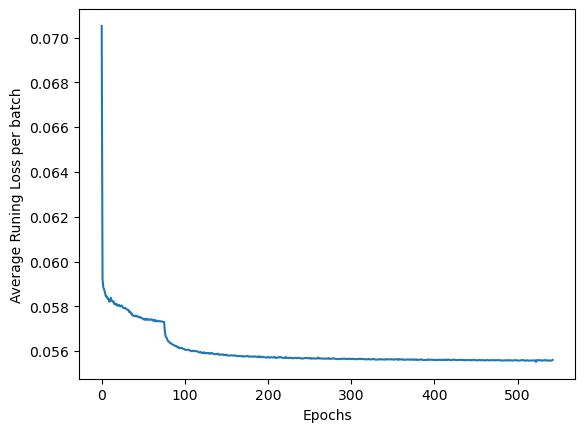

In [16]:
epoch_arr = np.arange(0, len(avg_loss_list))
loss_arr = np.array(avg_loss_list)
plt.plot(avg_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [17]:
torch.save(final_model, 'model_100206_11g_04_retrain1.pt')